In [1]:
from phantominator import shepp_logan
from matplotlib import pyplot as plt

import torch

from loguru import logger
import pathlib
from natsort import natsorted, ns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from quantization import *
from weight_compressors import *
from hyperparameter_sweeps import *
from benchmarkers import *

In [4]:
# SMALL_SIZE = 12
# MEDIUM_SIZE = 16
# BIGGER_SIZE = 18

# plt.rc('font', size=SMALL_SIZE)
# plt.rc('axes', titlesize=BIGGER_SIZE, titlecolor="white")  
# plt.rc('axes', labelsize=MEDIUM_SIZE, labelcolor="white")    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE, color="white")    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE, color="white")    # fontsize of the tick labels

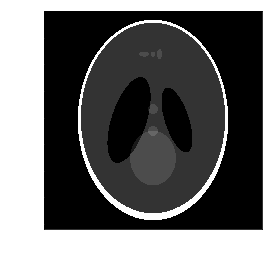

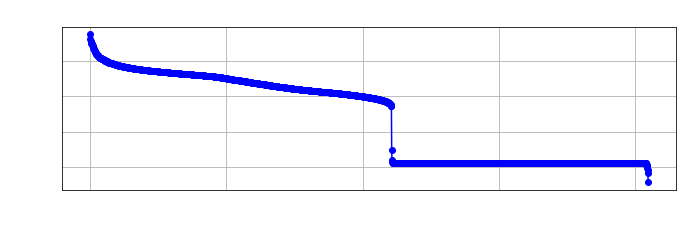

In [5]:
# Generate a phantominator matrix
X = torch.Tensor(shepp_logan(2048))
plt.imshow(X, cmap="gray", interpolation="nearest")
plt.show()

_, S, _ = torch.linalg.svd(X.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(11, 3))
plt.plot(S, marker='o', linestyle='-', color='b')
plt.title('Singular Values of Phantom(1024)', color="white")
plt.xlabel('Index', color="white")
plt.ylabel('Singular Value', color="white")
plt.yscale('log')
plt.grid(True)
plt.show()

In [6]:
def test_alternating_mixed_lplr(
    lplr_params=[{
        "alpha": 0.5, # Fraction of retained columns to be in full precision
        "beta": 0.4, # Fraction of columns to be retained
        "B1": 8,
        "B2": 8,
        "quantization_fn": quantize
    }],
    device="cpu",
    iters=50
):

    plot_colors = ["b", "r", "g", "c", "m", "k"]
    plot_markers = ["o", "X", "*"]
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Generate a phantominator matrix
    X = torch.Tensor(shepp_logan(2048))
    X = X.to(device)
    print(f"Phantom shape: {X.shape[1]}")

    plt.figure(figsize=(11, 3))

    for i, param_set in enumerate(lplr_params):
        kwargs = param_set.copy()
        kwargs["k"] = int(kwargs["beta"] * X.shape[1])
        kwargs["r1"] = int(kwargs["alpha"] * kwargs["k"])
        kwargs["r2"] = kwargs["r1"]
        kwargs["normalize_and_shift"] = False
        kwargs["log_errors"] = True
        kwargs["iters"] = iters
        del kwargs["alpha"]
        del kwargs["beta"]

        # Call alternating_mixed_lplr and retrieve errors
        kwargs["X"] = X
        _, _, out, errors = alternating_mixed_lplr(**kwargs)
        

        fro_norm_X = torch.norm(X, p="fro").item()
        relative_errors = [error / fro_norm_X for error in errors]

        # Plot errors over iterations
        
        plt.plot(
            range(1, len(relative_errors) + 1),
            relative_errors,
            marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
            linestyle="-",
            markersize=4,
            color=plot_colors[i % len(plot_colors)],
            label=f"Param Set {i+1}*")

    print("-"*80, "\n* Legend Key")
    for i, kwargs in enumerate(lplr_params):
        print(F"Param Set {i+1}: ", kwargs)

    plt.title("Frobenius Norm Errors over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

In [29]:
_, _, errors = alternating_mixed_lplr_plus_q(X.to("cuda:2"), k=255, r1=100, r2=100, BQ=4, log_errors=True, inner_iters=50, outer_iters=2)

tensor([1.3298e+01, 3.5038e+00, 2.7451e+00, 1.8522e+00, 1.3193e+00, 1.1940e+00,
        9.8718e-01, 8.3729e-01, 7.3200e-01, 6.6453e-01, 6.3616e-01, 5.6747e-01,
        4.8860e-01, 4.6319e-01, 4.2529e-01, 4.1052e-01, 3.9627e-01, 3.6910e-01,
        3.3254e-01, 3.0530e-01, 2.9933e-01, 2.8887e-01, 2.7759e-01, 2.7564e-01,
        2.5417e-01, 2.4870e-01, 2.3905e-01, 2.3145e-01, 2.2265e-01, 2.1200e-01,
        2.1036e-01, 2.0582e-01, 1.9820e-01, 1.8701e-01, 1.8068e-01, 1.7778e-01,
        1.7361e-01, 1.6886e-01, 1.6476e-01, 1.6013e-01, 1.5526e-01, 1.5109e-01,
        1.4808e-01, 1.4565e-01, 1.4028e-01, 1.3851e-01, 1.3462e-01, 1.3314e-01,
        1.3149e-01, 1.2937e-01, 1.2708e-01, 1.2513e-01, 1.2330e-01, 1.2004e-01,
        1.1912e-01, 1.1637e-01, 1.1586e-01, 1.1301e-01, 1.1169e-01, 1.0897e-01,
        1.0793e-01, 1.0606e-01, 1.0496e-01, 1.0275e-01, 1.0178e-01, 1.0002e-01,
        9.8628e-02, 9.7865e-02, 9.6665e-02, 9.6468e-02, 9.2613e-02, 9.2060e-02,
        9.0753e-02, 8.9659e-02, 8.8939e-

  0%|          | 0/49 [00:00<?, ?it/s]


In [30]:
1.3298e+01 / 2.6028e-06

5109113.262640234

In [31]:
1.3298e+01 / 3.2350e-06

4110664.605873261

In [28]:
np.array(errors) / torch.norm(X, p="fro").item()

array([8.70668721e-05])

Phantom shape: 2048


100%|██████████| 49/49 [00:04<00:00, 11.18it/s]


-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'alpha': 0.5, 'beta': 0.4, 'B1': 8, 'B2': 8, 'quantization_fn': <function quantize at 0x7fb1bfb65268>}
Param Set 2:  {'alpha': 0.5, 'beta': 0.4, 'B1': 8, 'B2': 8, 'quantization_fn': <function quantize_nf at 0x7fb1bfb7e400>}


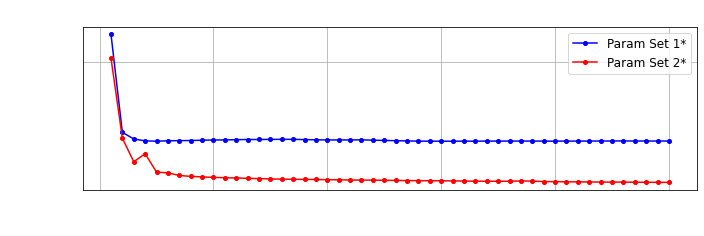

In [20]:
test_alternating_mixed_lplr([
    {
        "alpha": 0.5, # Fraction of retained columns to be in full precision
        "beta": 0.4, # Fraction of columns to be retained
        "B1": 8,
        "B2": 8,
        "quantization_fn": quantize
    },
    {
        "alpha": 0.5, # Fraction of retained columns to be in full precision
        "beta": 0.4, # Fraction of columns to be retained
        "B1": 8,
        "B2": 8,
        "quantization_fn": quantize_nf
    }
], device="cuda:2")

In [79]:
def test_loftq(
    lplr_params=[{
        "beta": 0.2, # Fraction of columns to be retained
        "B": 8,
        "quantization_fn": quantize_nf
    }],
    iters=50,
    device="cpu"
):

    plot_colors = ["b", "r", "g", "c", "m", "k"]
    plot_markers = ["o", "X", "*"]
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Generate a phantominator matrix
    X = torch.Tensor(shepp_logan(2048))
    print(f"Phantom shape: {X.shape[1]}")

    plt.figure(figsize=(11, 3))

    for i, param_set in enumerate(lplr_params):
        kwargs = param_set.copy()
        kwargs["r"] = int(kwargs["beta"] * X.shape[1])
        kwargs["normalize_and_shift"] = True
        kwargs["log_errors"] = True
        kwargs["iters"] = iters
        del kwargs["beta"]

        # Call alternating_mixed_lplr and retrieve errors
        kwargs["X"] = X.to(device)
        _, _, _, _, errors = loftq(**kwargs)

        fro_norm_X = torch.norm(X, p="fro").item()
        relative_errors = [error / fro_norm_X for error in errors]

        # Plot errors over iterations
        
        plt.plot(
            range(1, iters + 1),
            relative_errors,
            marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
            linestyle="-",
            markersize=4,
            color=plot_colors[i % len(plot_colors)],
            label=f"Param Set {i+1}*")

    print("-"*80, "\n* Legend Key")
    for i, kwargs in enumerate(lplr_params):
        print(F"Param Set {i+1}: ", kwargs)

    plt.title("Frobenius Norm Errors over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

Phantom shape: 2048


100%|██████████| 50/50 [00:32<00:00,  1.55it/s]


-------------------------------------------------------------------------------- 
* Legend Key
Param Set 1:  {'beta': 0.2, 'B': 8, 'quantization_fn': <function quantize_nf at 0x7fb1bfb7e400>}


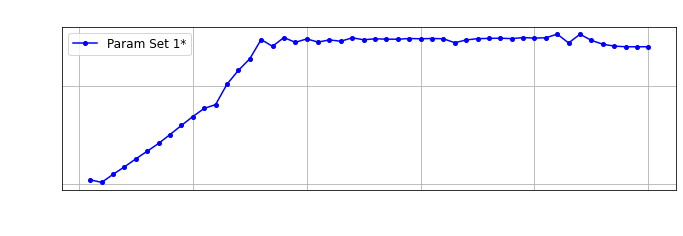

In [80]:
test_loftq(device="cuda:2")

In [94]:
X = torch.Tensor(shepp_logan(2048)).to("cuda:2")
average_bit_level = 3
budget = X.shape[0] * X.shape[1] * average_bit_level

mtxs, alpha, beta, B, error = lplr_sweep_alpha_and_B(
    X=X, budget=budget,
    kwarg_dict={"quantization_fn": quantize_nf, "iters":50, "normalize_and_shift": True},
    lplr_type=LplrType.ALTERNATING_MIXED,
    debug=True)

TypeError: lplr_sweep_alpha_and_B() got an unexpected keyword argument 'kwarg_dict'

In [38]:
def compare_against_benchmarks(
    X_list:list = None,
    average_bit_level:int = 3,
    benchmarkers=[],
    reset_error_lists = True
):
    for X in X_list:
        n, d = X.size()
        budget = n*d*average_bit_level

        for benchmarker in benchmarkers:
            if reset_error_lists:
                benchmarker.reset_errors()
            benchmarker.run(X, budget)
            
    for benchmarker in benchmarkers:
        print(f"{benchmarker.label}: {benchmarker.errors}")

In [45]:
benchmarkers = [
        LplrBenchmarker(
            {
                "quantization_fn": quantize_nf,
                "iters": 50,
                "alpha_start": 0,
                "alpha_stop": 0.5,
                "alpha_step": 0.1,
                "prune": True
            },
            label="Mixed Alternating LPLR (B=8)"
        ),
        DirectSvdBenchmarker(
            {
                "quantization_fn": quantize_nf,
                "alpha_start": 0,
                "alpha_stop": 0.5,
                "alpha_step": 0.1,
                "prune": True
            }
        ),
        FullQuantBenchmarker(
            {
                "quantization_fn": quantize,
            },
            label="Uniform Quantization"
        ),
        FullQuantBenchmarker(
            {
                "quantization_fn": quantize_nf,
                "iters": 50
            },
            label="Normal Float Quantization"
        ),
        LoftqBenchmarker(
            {
                "quantization_fn": quantize_nf,
                "B": 2,
                "iters": 50
            },
            label="LoftQ (B=2)"
        ),
    ]

In [48]:
# model_directory = pathlib.Path("/hdd/models/Mistral-7B-v0.1-bf16-sharded/")
model_directory = pathlib.Path("/mnt/sda2/models/Mistral-7B-v0.1-bf16-sharded/")
model_files = natsorted(model_directory.glob("*.bin"), alg=ns.IC)
f = model_files[0]
layer_set = torch.load(f, map_location="cpu")
name, X2 = list(layer_set.items())[1]
X2 = X2.float().to("cuda:2")

In [46]:
for (name, W) in layer_set.items():
    print(name, ": ", W.shape)

model.embed_tokens.weight :  torch.Size([32000, 4096])
model.layers.0.self_attn.q_proj.weight :  torch.Size([4096, 4096])
model.layers.0.self_attn.k_proj.weight :  torch.Size([1024, 4096])
model.layers.0.self_attn.v_proj.weight :  torch.Size([1024, 4096])
model.layers.0.self_attn.o_proj.weight :  torch.Size([4096, 4096])
model.layers.0.mlp.gate_proj.weight :  torch.Size([14336, 4096])
model.layers.0.mlp.up_proj.weight :  torch.Size([14336, 4096])
model.layers.0.mlp.down_proj.weight :  torch.Size([4096, 14336])
model.layers.0.input_layernorm.weight :  torch.Size([4096])
model.layers.0.post_attention_layernorm.weight :  torch.Size([4096])
model.layers.1.self_attn.q_proj.weight :  torch.Size([4096, 4096])
model.layers.1.self_attn.k_proj.weight :  torch.Size([1024, 4096])
model.layers.1.self_attn.v_proj.weight :  torch.Size([1024, 4096])
model.layers.1.self_attn.o_proj.weight :  torch.Size([4096, 4096])
model.layers.1.mlp.gate_proj.weight :  torch.Size([14336, 4096])
model.layers.1.mlp.up_

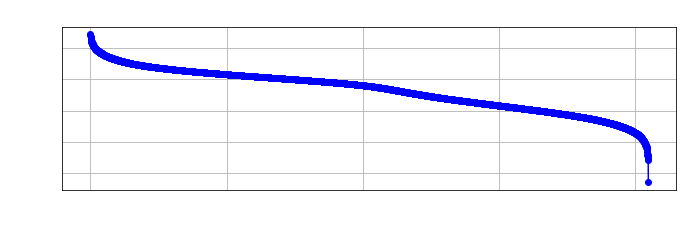

In [50]:
_, S, _ = torch.linalg.svd(X2.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(11, 3))
plt.plot(S.cpu(), marker='o', linestyle='-', color='b')
plt.title('Singular Values of Layer Weights')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.yscale('log')
plt.grid(True)
plt.show()

In [51]:
compare_against_benchmarks([X2], benchmarkers=benchmarkers)

100%|██████████| 49/49 [00:09<00:00,  5.26it/s]
2024-01-09 19:48:35.251 | WARNING  | hyperparameter_sweeps:lplr_sweep_alpha:73 - Error increased after increasing alpha and prune is set to True. Giving up.
2024-01-09 19:49:21.494 | WARNING  | hyperparameter_sweeps:lplr_sweep_alpha:73 - Error increased after increasing alpha and prune is set to True. Giving up.
100%|██████████| 50/50 [04:11<00:00,  5.04s/it]

Mixed Alternating LPLR (B=8): [0.04197975055840411]
Direct SVD: [0.04622669745813277]
Uniform Quantization: [0.9495973025925873]
Normal Float Quantization: [0.8026467172578212]
LoftQ (B=2): [0.2068842819899936]


In [8]:
def absmax_quantize_int8(X: torch.Tensor) -> tuple[torch.Tensor, torch.float16]:
    """Quantize each float16/32 data type to int8 and return the maximum value in float16"""
    scale = X.abs().max().item() / 127.0
    int8_tensor = (X / scale).round().to(torch.int8)
    return scale, int8_tensor

In [9]:
def absmax_dequantize_int8(Xq: torch.Tensor, scale: torch.float16) -> torch.Tensor:
    """Dequantize int8 data type to float16/32"""
    return Xq.to(torch.float16) * scale